# 5장 서포트 벡터 머신

## 핵심 주제

서포트 벡터 머신의 개념, 활용, 작동원리를 살펴본다.

1. 라지 마진 분류
1. 선형 SVM 분류
    1. 특성 스케일 조정
    1. 하드/소프트 마진 분류
1. 비선형 SVM 분류
    1. 선형 SVM + 다항 회귀
    1. SVC + 커널 트릭
        1. 다항식 커널
        1. 가우시안 RBF 커널
1. SVM 회귀
1. SVM 이론
    1. 결정함수와 예측
    1. 목적 함수
    1. 콰드라틱 프로그래밍
    1. 쌍대 문제
    1. 커널 SVM
    1. 온라인 SVM

## 파이썬 기본 설정

* 파이선 버전 3.5 이상
* 사이킷런 버전 0.20 이상
* 모듈 불러오기
    * numpy
    * matplotlib
    * matplotlib.pyplot
* 그림 저장 위치 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 핵심 1: 라지 마진 분류

서포트 벡터 머신(support vector machine, SVM) 분류기는 
클래스를 구분하는 가장 넓은 도로를 찾는 방식으로 학습한다.
이러한 분류 방식을 **라지 마진 분류**라고 부른다. 

4장에서 소개한 붓꽃 데이터셋의 일부를 대상으로 선형 분류기를 이용한 클래스 분류와
SVM 분류기를 이용한 클래스 분류 결과의 차이를 보여주고자 한다. 

아래 코드의 내용은 다음과 같다.

* 붓꽃 데이터셋에서 꽃잎의 길이와 너비 정보를 특성으로 갖는
    훈련 세트 `X`와 레이블(타깃) `Y` 지정.
* 이진 분류 훈련을 위해 setosa와 versicolor 두 품종만 훈련 세트에 포함시킴
* `SVC` 분류기 설정: SVM 분류기로 `SVC` 분류기 클래스 활용

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()

# 꽃잎 길이, 꽃잎 너비 정보만 가져옴
X = iris["data"][:, (2, 3)]
y = iris["target"]

# setosa와 versicolor 품종 데이터만 사용
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델: SVC 분류기 사용
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

아래 코드는 두 개의 그래프를 그린다.

* 왼편 그래프: 선형 분류기를 이용한 클래스 분류
    * 빨간색 실선과 마젠타(심홍색)색 실선
        * 훈련 세트 분류 잘함. 
        * 하지만 결정 경계가 샘풀에 너무 붙어 있음. 새로운 샘플에 잘 적응하지 못할 것임.
    * 초록색 점선: 제대로 분류 못함
* 오른편 그래프: SVC 분류기 활용 선형 클래스 분류
    * 실선: SVC 분류기의 **결정 경계**
        * 두 클래스로부터 최대한 멀리 떨어져 있음.
        * 즉, 제일 가까운 훈련 샘플(**서포트 벡터**)로부터 최대한 멀리 떨어져 있음.
    * 점선: 두 클래스 사이의 **도로 폭(마진)이 최대각 되도록 하는 경계선**
    
먼저 선형모델을 직접 1차 함수로 지정한다.    

In [3]:
# 선형 분류 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

다음 함수는 결정 경계와 도로 경계를 그려주며,
SVM 분류 모델의 성능을 확인할 때 많이 사용된다.

In [4]:
# SVC 분류기에 의해 생성된 결정 경계와 도로 경계 그리기 함수
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    # 학습된 가중치
    w = svm_clf.coef_[0]
    # 학습된 편향
    b = svm_clf.intercept_[0]

    # 결정 경계 함수: w0*x0 + w1*x1 + b = 0
    # 따라서, 결정 경계 그래프의 수직축 값: x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    # 마진 확인: 결정 경계 함수의 기울기가 서포트 벡터까지의 거리에 반비례하게 결정되었음.
    # 아래 margin 변수는 도로폭의 1/2에 해당함.
    margin = 1/w[1]
    # 도로 경계 확인
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    # 서포트 벡터 확인 및 표시
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    
    # 결정 경계 및 도로 그리기
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

이제 그래프를 그린다.

그림 저장: large_margin_classification_plot


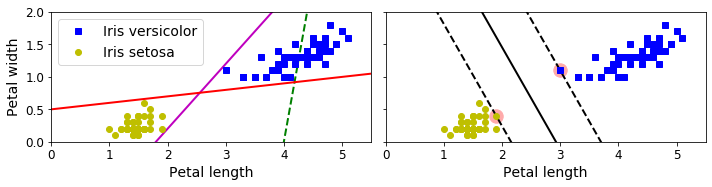

In [5]:
# 그래프 그리기 설정    
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼편 그래프 그리기
plt.sca(axes[0])
# 선형 모델
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
# 훈련 세트 표시
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

# 오른편 그래프 그리기
plt.sca(axes[1])
# SVM 모델
plot_svc_decision_boundary(svm_clf, 0, 5.5)
# 훈련 세트 표시
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

## 핵심 2: 선형 SVM 분류

앞서 사용된 오른편 그림에서 확인할 수 있듯이
SVM 분류기는 두 클래스로부터 최대한 멀리 떨어져 있는 결정 경계를 찾는다. 
즉, 제일 가까운 훈련 샘플로부터 가능한 멀리 떨어지도록 학습한다. 

그러한 결정 경계는 두 클래스 사이를 지나가는 도로 폭(**마진**)이 특정 조건하에 
최대각 되도록 하는 경계선을 구하는 방식으로 찾아진다.
이때, 도로의 양쪽 경계에 위치하는 훈련 세트는 **서포트 벡터**라 부른다.
즉, **결정 경계는 서포트 벡터로부터 최대한 멀리 떨어지도록 학습된다**. 

### 특성 스케일 조정

SVM 분류기는 특성의 스케일에 민감하다. 
아래 코드는 수직축과 수평축의 스케일이 다른 경우와 `standardScaler` 변환기를 활용하여
스케일을 조정한 경우 결정 경계의 성능이 어떻게 달라지는가를 잘 보여준다.

* 왼편 그래프: 스케일 조정이 되지 않은 네 개의 훈련 샘플을 이용한 SVC 분류기 학습
* 오른편 그래프: `StandardScaler` 변환기를 이용하여 스케일을 조정한 후 SVC 분류기 학습

그림 저장: sensitivity_to_feature_scales_plot


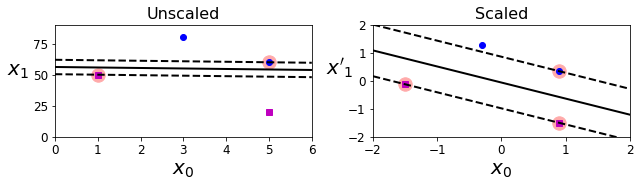

In [6]:
# 왼편 그래프: 스케일 조정 되지 않은 훈련 세트 학습
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# 오른편 그래프: 스케일 조정 후 학습 하기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")


### 하드/소프트 마진 분류

두 가지 마진 분류 방식이 사용된다.

* 하드 마진 분류(hard margin classification)
    * 모든 훈련 샘플이 도로 바깥쪽에 올바르게 분류되도록 하는 마진 분류
    * 훈련 세트가 선형적으로 구분되는 경우에만 가능
    * 이상치에 매우 민감
* 소프트 마진 분류(soft margin classification)
    * 마진 위반(margin violation) 발생 정도를 조절하면서 도로의 폭을 최대로 넓게 유지하는 마진 분류


여기서 **마진 위반**은 훈련 샘플이 도로 상에 위치하거나 심지어 
결정 경계를 넘어 해당 클래스 반대편에 위치하는 사례를 가리킨다.

**주의**: 책에서는 '마진 오류'로 번역하였다. 
하지만 영어 표현(margin violation)에서 알 수 있듯이 오류 보다는 마진을 위반하는 사례를 뜻한다.
따라서 여기서는 마진 위반을 대신 사용한다.

#### 하드 마진 분류의 단점

아래 코드는 이상치 때문에 발생하는 하드 마진 분류의 단점 두 가지를 보여준다.

* 왼편 그래프: 이상치가 다른 클래스에 섞여 있어서 하드 마진 분류가 아예 불가능한 경우
    * 책 206쪽, 그림 5-2와는 달리 왼편 그림에 결정 경계를 추가하였음.
    * 하드 마진 분류가 가능하지 않음을 이미지가 잘 보여줌.
* 오른편 그래프: 이상치가 다른 클래스에 매우 가까이 붙어 있음.
    * 하드 마진 분류 가능. 하지만 일반화 어려움.
    * 즉, 예측 성능이 좋지 않을 것임.

그림 저장: sensitivity_to_outliers_plot


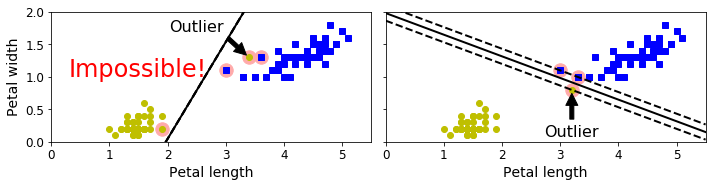

In [7]:
# 이상치 두 개 설정
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
# 두 이상치 모두 setosa 품종으로 지정
y_outliers = np.array([0, 0])

# 왼편 이미지용 이상치 추가
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)

# 오른편 이미지용 이상치 추가
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

# 왼편 이미지용 SVC 선형 분류기
svm_clf1 = SVC(kernel="linear", C=10**9)
svm_clf1.fit(Xo1, yo1)

# 오른편 이미지용 SVC 선형 분류기
svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼편 이미지 그리기
# 하드 마진 분류가 불가능함을 보여줌
plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plot_svc_decision_boundary(svm_clf1, 0, 5.5)
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

# 오른편 이미지 그리기
# 하드 마진 분류 가능
plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

#### 마진 위반과 규제

### `C` 매개변수 규제를 이용하여 허용되는 마진 위반의 발생을 조절한다. 

* `C`가 클 때: 
    * 결정경계의 기울기의 절댓값이 커져서 도로폭이 좁아짐
    * 마진 위반 적게 발생
    * 모델의 유연성(예측도) 떨어짐.
* `C`가 작을 때: 
    * 결정경계의 기울기의 절댓값이 작아져서 도로폭이 넓어짐.
    * 마지 위반 많이 발생
    * 모델의 유연성(예측도) 좋아짐.

마진 위반과 `C`의 관계는 이후 SVM 작동 이론을 다룰 때 보다 자세히 설명한다. 

##### 예제: 붓꽃 품종 분류

아래 코드는 선형 SVM 분류기 `LinearSVC`을 이용하여 virginica 품종인지 아닌지 여부를 판단한다.
virginica 품종이 양성(1)이고 나머지는 모두 음성(0)으로 처리된다.
즉, 이진 분류기를 학습한다. 

* `svm_clf`: `StandardScaler`로 특성 스케일을 진행하고, `linearSVC` 를 이용하여 분류 학습 진행.
* `LinearSVC` 옵션
    * `C=1`: 비교적 약한 규제
    * `loss="hinge"`: 모델 학습 과정에 사용되는 손실 함수(loss function)를 `hinge` 함수로 지정.
    * `hinge` 함수는 이후 온라인 SVM을 다룰 때 보다 자세히 설명할 것임.
* 예측 샘플: `[5.5, 1.7]`
    * 결과: 1, 즉, virginica 맞음.

In [8]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# 붓꽃 데이터셋 불러오기
iris = datasets.load_iris()
# 꽃잎 길이와 너비 속성만 훈련 세트로 활용
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
# Iris virginica 품종이면 양성, 아니면 음성. 즉, 이진 분류용으로 설정.
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

# 파이프라인 설정
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

# 모델 학습
svm_clf.fit(X, y)

# 샘플의 레이블 예측하기
svm_clf.predict([[5.5, 1.7]])

array([1.])

아래 코드는 규제 `C` 값을 다르게 할 때의 달라지는 결과를 보여준다. 
`C` 값이 클 수록 결정경계가 보다 가팔라짐에 유의하라.
즉, `C` 값이 클 수록 보다 정교한 클래스 분류가 가능해진다.

* 왼편 그래프: `C = 1`
    * 결정 경계 도로폭이 넓다.
    * 덜 정교한 분류 가능
* 오른편 그래프: `C = 100`
    * 결정 경계 도로폭이 좁다.
    * 보다 정교한 분류 가능

그림 저장: regularization_plot


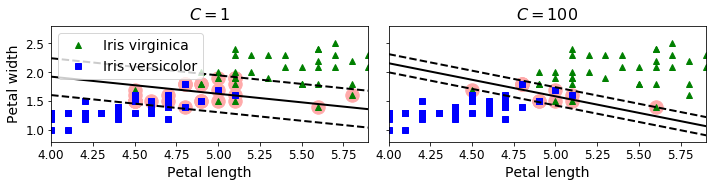

In [9]:
# 스케일 변환기 설정
scaler = StandardScaler()

# 선형 SVC 모델 설정. C 값 다름.
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

# 선형 SVC 모델에 따른 파이프라인 설정. 특성 스케일링 추가.
scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])

scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

# 두 선형 모델 학습
# fit 결과는 각각 svm_clf1과 svm_clf2에 저장됨.
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

# 스케일 되돌리기
# 데이터 원본과 함께 결정 경계를 표시하려면 원래의 스케일로 수치를 환산해야 함.
# 이유는 학습은 특성 스케일이 된 훈련 데이터로 이루어졌기 때문.
# 주의: 원본 데이터는 그대로임. 스케일링은 원본 데이터는 건드리지 않고 복사해서 사용함.
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_

# plot_svc_decision_bounday() 함수에 필요한 값
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않아, 수동으로 지정함.
# 역시 plot_svc_decision_bounday() 함수에 필요함.
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

# 그래프 두 개 그리기
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼편 그래프 그래기
plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

# 오른편 그래프 그리기
plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

### 선형 SVM 지원 분류기

선형 SVM 분류기는 아래 클래스를 이용하여 생성할 수 있다.

* `LinearSVC`: 바로 앞에서 설명됨.
* `SVC` + 선형 커널
    * 예제: `SVC(kernel="linear", C=1)`
    * 앞서 SVM 설명할 때 사용되었음.
* `SGDClassifier` + `hinge` 손실함수 활용 + 규제: 
    * 예제: `SGDClassifier(loss="hinge", alpha=1/(m*C))`
    * `m`: 훈련 샘플 수
    * 즉, 규제 강도가 훈련 샘플 수에 반비례 함.
        훈련 샘플 수가 많으면 규제가 약해도 된다는 의미.

## 핵심 3: 비선형 분류

비선형 데이터셋을 분류하는 방법을 알아본다.

* 선형 SVM + 다항 회귀: 4장에서 배운대로 다항 특성을 추가한 후 선형 SVM 적용.
* `SVC` + 커널 트릭: 새로운 특성을 실제고 추가하지 않지만, 동일한 결과를 유도하는 방식
    * 예제 1: 다항식 커널
    * 예제 2: 가우시안 RBF 커널

### 선형 `SVM` + 다항 회귀

아래 코드는 2차항 특성을 추가하면 비선형 분류 문제를 해결할 수 있음을 보여준다.

* 왼편 그래프: 비선형 기본 데이터
* 오른편 그래프: 2차항 특성이 추가되어 `x2=4.5`를 지나는 평행선으로 분류가 가능함을 보여줌.

**주의**: 분류기를 직접 사용하지는 않았음.

그림 저장: higher_dimensions_plot


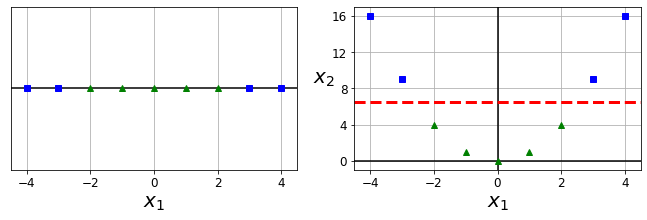

In [10]:
# 기본 데이터
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
# x1D의 제곱에 해당하는 특성 추가
X2D = np.c_[X1D, X1D**2]
# 레이블
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

# 그래프 그리기
plt.figure(figsize=(10, 3))

# 왼편 그래프
plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

# 오른편 그래프
plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

#### 예제: `LinearSVC` + 다항 회귀

비선형 분류를 위해 `moons` 데이터셋을 사용한다. 
`moons` 데이터셋은 마주보즌 두 개의 반원 모양으로 두 개의 클래스로 구분되는 데이터를 갖고 있다.
사이킷런에서 `moons` 데이터셋을 아래와 같이 준비할 수 있다.

* `n_samples`: 샘플 수
* `noise`: 추가되는 가우시안 잡음의 표준편차

아래 코드는 또한 선택된 데이터셋의 그래프도 함께 보여준다.

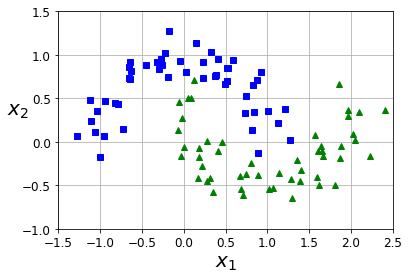

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

`LinearSVC`와 다항 회귀를 연합하면 비선형 분류가 가능해진다.

* `PolynomialFeatures(degree=3)`: 3차 다항까지 추가

/opt/conda/envs/tf2/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


그림 저장: moons_polynomial_svc_plot


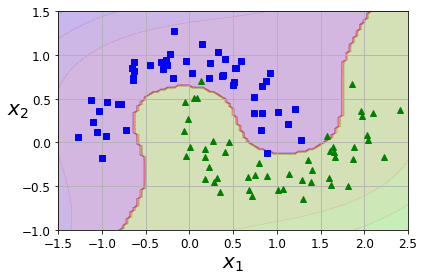

In [12]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# 3차 다항까지 추가
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

# 학습
polynomial_svm_clf.fit(X, y)

# 그래프 그리는 함수
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

### SVC + 커널 트릭

다항식 특성을 추가하는 방법은 매우 유용하다.
하지만 고차항 다항식은 많은 특성으로 인해 모델을 매우 느리게 만들 수 있다. 

반면에 커널 트릭(kernel trick)을 사용하면 수학적 기교를 이용하여 다항식 특성을 추가하는 효과를 얻을 수 있다.
즉, 어떤 특성도 추가하지 않으면서 수학적으로 동일한 결과가 나오게 할 수 있다.
여기서는 앞서 많은 예제에서 사용한 선형 커널(`kernel="linear"`) 이외에 두 가지 방식을 더 소개한다. 

* 다항식 커널
    * 다항 회귀에서처럼 다항식 커널을 추가하는 효과를 얻음.
* 가우시안 RBF 커널
    * 방사 기저 함수(radal basis function, RBF)를 유사도 함수로 활용하는 방식과 동일한 효과를 얻음.

#### 다항식 커널

아래 코드는 `SVC`에 다항식 커널 옵션을 장착하여 
`moons` 데이터셋을 대상으로 비선형 분류기를 학습시키는 방법을 소개한다.

* 왼편 그래프
    * `kernel="poly"`: 다항식 커널
    * `degree=3`: 3차 다항식 커널 활용
    * `coef0=1`: 높은 차수에 영향을 주는 정도 지정. 1은 조금 영향 줌. 기본값은 0.
    * `C=5`: 마진 약간 크게
* 오른편 그래프
    * `kernel="poly"`: 다항식 커널
    * `degree=10`: 10차 다항식 커널 활용
    * `coef0=100`: 높은 차수에 영향을 주는 정도 지정. 100은 많은 영향 줌. 기본값은 0.
    * `C=5`: 마진 약간 크게    

그림 저장: moons_kernelized_polynomial_svc_plot


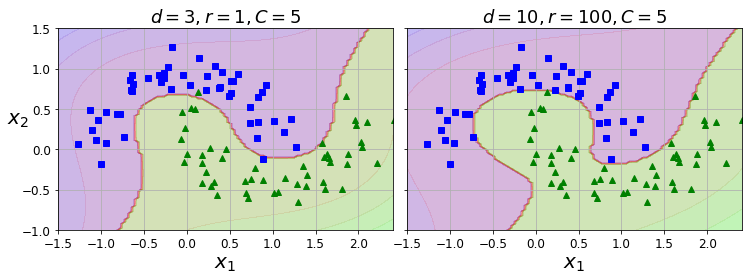

In [13]:
from sklearn.svm import SVC

# 다항식 커널 지정
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

# 그래프 그리기
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# 왼편 그래프
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

# 오른편 그래프
plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

##### 적절한 하이퍼파라미터 선택

* 모델이 과대적합이면 차수를 줄여야 한다.
* 적절한 하이퍼파라리머튼 그리드 탐색 등을 이용하여 찾는다.
    * 처음에는 그리드의 폭을 크게, 그다음에는 좀 더 세밀하게 검색한다.
    * 하이퍼파라미터의 역할을 잘 알고 있어야 한다.

#### 가우시안 RBF 커널

유사도 특성을 추가해서 모델 학습을 진행하는 방식을 커널 트릭을 이용하여 지원할 수 있다.
먼저 유사도 특성을 알아보자.

##### 유사도 특성

각 샘플이 특정 **랜드마크**(landmark)와의 유사도를 계산하는 
**유사도 함수**(similarity function)로 계산한 특성을 **유사도 특성**이라 부른다. 

예를 들어, 다음 두 개의 랜드마크를 추가하자.(아래 그래프의 왼편 그래프)

> $x_1 = -2$ 와 $x_1 = 1$

이제 가우시안 방사 기저 함수(RBF)를 유사도 함수로 사용한다. 

$$
\phi(\mathbf x, \ell) = \exp(-\gamma\, \lVert \mathbf x - \ell \lVert^2)
$$

* $\ell$: 랜드마크를 가리킴
* $\gamma$: 랜드마크에서 멀어질 수록 0에 수렴하는 속도를 조절함.
    * $\gamma$ 값이 클 수록 가까운 샘플을 보다 강조함.
        따라서 보다 정교하게 작동하는 모델 학습. 즉, 과대적합 위험 커짐.
    * 여기서는 $\gamma=0.3$ 사용.

이 함수의 값은 아래 두 값 사이에 분포한다.

* 0: 랜드마크에서 아주 멀리 떨어진 경우
* 1: 랜드마크와 같은 위치인 경우

아래 코드는 언급한 두 개의 랜드마크와의 유사도를 가우시안 RBF 함수로 계산할 때
새로운 특성 두 개 $x_1$과 $x_2$가 가질 수 있는 값들을 그래프로 그린 것이다.

그림 저장: kernel_method_plot


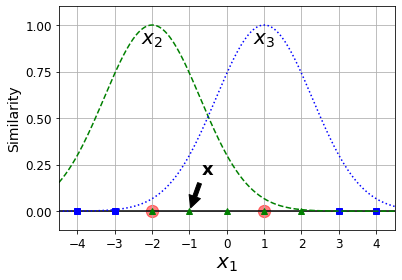

In [14]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

# 유사도 함수 그리기
x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
# 랜드마크 -2와의 유사도
x2s = gaussian_rbf(x1s, -2, gamma)
# 랜드마크 1과의 유사도
x3s = gaussian_rbf(x1s, 1, gamma)

# 훈련 세트: 샘플 9개
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)

# 9개 훈련 샘플에 대한 유사도
XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
# 9개 훈련 샘플에 대한 레이블
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

# 그래프 그리기
plt.figure(figsize=(10.5, 4))

# 책과 이미지 크기 맞추기 위해 사용됨
plt.subplot(121)

# x2와 x3의 유사도 함수 그래프 그리기
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)

# x=1: 화살표 표기
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

save_fig("kernel_method_plot")
plt.show()

**주의**: 윗쪽 아랫족 이미지에서 $\mathbf x$는 -1을 가리킨다. 

아래 코드는 계산된 유사도 값 $x_2$와 $x_3$의 관계를 이용하여 클래스 분류가 가능함을 보여준다. 

그림 저장: kernel_method_plot


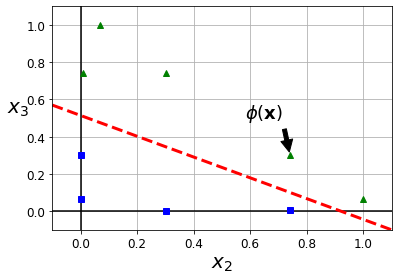

In [15]:
plt.figure(figsize=(10.5, 4))

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)

# phi(x), x=1: 화살표 표기
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

위 이미지에서 $\phi(\mathbf x)$: $\mathbf x = 1$에 대한 유사도 좌표 ($x_2$와 $x_3$)를 가리키며,
아래와 같이 구해진다. 

In [16]:
# x1_example = -1
x1_example = X1D[3, 0]

# 각각의 랜드마크에 대한 유사도 측정
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


##### 예제: `SVC` + 가우시안 RBF 커널

가우시안 RBF 함수를 유사도 함수로 사용하는 유사도 특성 방식을 SVC 커널로 지원한다.
아래 코드는 다양한 하이퍼파라미터에 따른 결과를 네 개의 그래프로 보여준다.

* `kernel="rbf"`
* `gamma` $\in \{ 0.1, 5\}$
* `C` $\in \{ 0.001, 1000\}$

다음 사항을 고려하면서 그래프를 이해해야 한다.

* `gamma`: 
    * 방사 기저 함수의 값을 보다 랜드마크에 집중하도록 만듦.
    * 값이 커질 수록 학습 모델이 샘플들 사이의 거리에 보다 민감하게 작동하도록 만듦.
    * 과대접합 요인이 커짐.
* `C`:
    * SVM 분류 모델 학습 과정에서 비용 함수 대신에 학습 기준으로 사용되는 목적함수에
        사용되는 파라미터
    * 값이 커질 수록 목적함수에 주는 규제가 약해져서, 가중치 벡터 노름 $\lVert w \lVert$가 커짐.
    * 따라서 결정 경계가 보다 세밀하게 그려짐. 즉, 과대적합 요인이 커짐.

그림 저장: moons_rbf_svc_plot


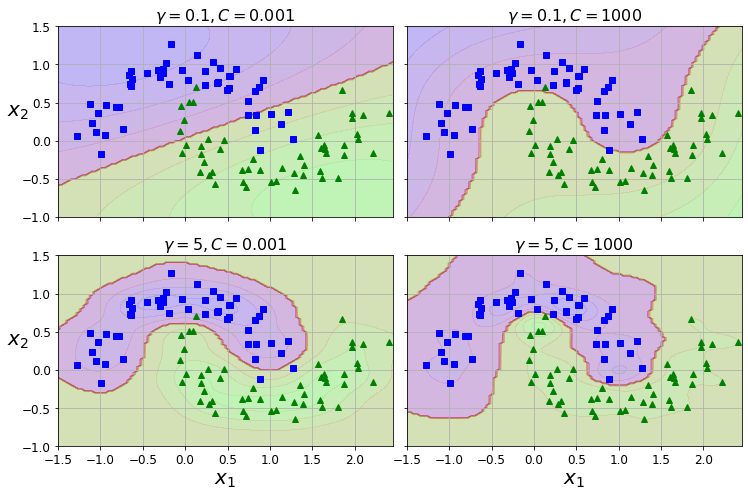

In [17]:
from sklearn.svm import SVC

# 하이퍼파라미터 조합 4개
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

# 네 개의 SVC 분류기 학습 후 리스트에 저장
svm_clfs = []

for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

# 그래프 네 개 그리기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

#### 추천 커널

* `SVC`의 `kernel` 기본값은 `"rbf"`이다. 
    대부분의 경우 이 커널이 잘 맞는다.
* 선형 모델이 예상되는 경우 `"linear"` 커널을 사용할 수 있다.
    하지만 훈련 세트가 크거나 특성이 아주 많을 경우 `LinearSVC`가 보다 빠르다. 
* 시간과 컴퓨팅 성능이 허락한다면 교차 검증, 그리드 탐색을 이용하여 적절한 커널을 찾아볼 수 있다.
    하지만 정말로 시간과 컴퓨팅 성능이 지원돼야 한다.
* 훈련 세트에 특화된 커널이 알려져 있다면 해당 커널을 사용한다.

**참조**: 다항식 커널과 가우시안 RBF 커널 이외에 다른 커널도 지원하지만 별로 사용되지 않는다. 
또한 문자열 커널(string kernel)과 같은 경우는 특정 데이터 구조에 특화되어 있다. 
* 문자열 서브시퀀스 커널(string subsequence kernel) 또는
* 레벤슈타인 거리(Levenshtein distance) 기반 커널  사용.

### 계산 복잡도

| 분류기  | 시간 복잡도($m$ 샘플 수, $n$ 특성 수) | 외부 메모리 학습  | 스케일 조정 | 커널 트릭  | 다중 클래스 분류 |
|---|---|---|---|---|---|
| LinearSVC  | $O(m \times n)$  | 미지원  | 필요 | 미지원 | OvR 기본 |
| SGDClassifier  | $O(m \times n)$ | 지원  | 필요 | 미지원 | 지원 | 
| SVC  | $O(m^2 \times n)\sim O(m^3 \times n)$ | 미지원 | 필요 | 지원  | OvR 기본|

* `LinearSVC`
    * 선형 SVM에 최적화된 `liblinear` 라이브러리 활용
    * 정밀도 높일 수록 길어짐.
        * 허용오차(`tol` 옵션변수) $\epsilon$으로 조절
        * 허용오차는 기본적으로 기본값 사용 추천
* `SGDClassifier`
    * 손실함수 옵션인 `loss`의 옵션 인자에 따라 선형 SVM, 로지스틱 회귀 등 다양한 방식으로
        다중 클래스/레이블 분류 지원
* `SVC`
    * 커널 트릭 지원하는 `libsvm` 라이브러리 활용
    * 복잡하지만 작거나 중간 규모의 훈련 세트에 적절함
    * **희소 특성**(sparse features, 각 샘플에 0이 아닌 특성이 몇 개 없는 경우)인 경우 확장 잘됨.
        * 샘플이 가진 0이 아닌 특성 수의 평균에 거의 비례

## 핵심 4: SVM 회귀

SVM 알고리즘을 약간 응용하면 선형, 비선형 회귀에서 사용할 수 있다.
차이점은 다음과 같다.

* SVM 분류: 마진 위반 발생 정도를 조절하면서 두 클래스 사이의 도로 폭(마진)을 최대한 넓게 하기
* SVM 회귀: 마진 위반 발생 정도를 조절하면서 도로 폭(마진)을 최대한 넓혀서 도로 위에 가능한 많은 샘플 포함하기

회귀 모델에서 **마진 위반**은 **도로 밖**에 위치한 샘플을 가리킨다.

### 선형 SVM 회귀

아래 코드는 `LinearSVR` 선형 SVM 회귀 모델을 이용하는 방법을 보여준다.
두 개의 그래프는 서로 다른 마진이 사용될 때의 차이를 잘 보여준다. 

* 왼편 그래프 마진: $\epsilon=1.5$의 두 배
* 오른편 그래프 마진: $\epsilon=1.5$의 두 배

**주의사항** 

* 허용오차 설명에서 사용된 하이퍼파라미터 $\epsilon$과 다른 의미임.
* `LinearSVR`과 `SVR`에서 사용되는 허용오차는 `tol` 옵션 변수로 지정됨.

먼저 두 개의 선형 SVM 객체를 지정하고,
각각의 경우에 서포트 벡터를 찾아 해당 정보를 인스턴스 속성으로 저장한다.

In [18]:
# LinearSVR 클래스 지정
from sklearn.svm import LinearSVR

# 훈련 세트 무작위 생성
# 레이블은 선형으로 지정 + 가우시안 잡음
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

# 두 개의 LinearSVR 예측기 구성

# epsilon: 1.5 또는 0.5
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

# 서포트 벡터 확인
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

# 서포트 벡터 속성 저장
svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

# epsilon(마진) 크기 양방향 화살표 표기 위치 지정
eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그래프를 그려주는 다음 함수는 비선형 SVM 회귀 부분에서도 사용된다.

In [19]:
# 그래프 그리는 함수
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

이제 각각의 경우에 해당하는 그래프를 그린다.

그림 저장: svm_regression_plot


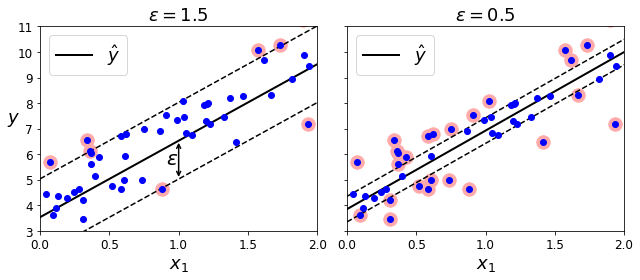

In [20]:
# 그래프 그리기
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

# 왼편 그래프
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

# 마진 양방향 화살표 표기
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)

# 오른편 그래프
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

### 비선형 SVM 회귀

아래 코드는 `SVR` SVM 회귀 모델을 이용하여 비선형 회귀를 구현하는 방법을 보여준다.
두 개의 그래프 모두 마진으로 $\epsilon=0.1$으로 사용한다. 
하지만 규제 옵션 `C`를 달리한다. 

* 왼편 그래프 규제: `C=100`
    * 가중치 벡터 노름 $\lVert w \lVert$에 대한 규제가 약해짐.
    * 보다 정교한 회귀 모델 구현
* 오른편 그래프 규제: `C=0.01`
    * 가중치 벡터 노름 $\lVert w \lVert$에 대한 규제가 강해짐.
    * 덜 정교한 회귀 모델 구현

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값이 될 `gamma="scale"` 사용.

먼저 비선형 회귀에 사용된 훈련 세트를 준비한다. 
2차 다항 회귀 모델용이며, 가우시안 잡음이 추가되었다. 

In [21]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

이제 지정된 규제를 사용하여 `SVR` 예측기를 생성한 후 학습을 진행한다.

In [22]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

이제 예측기 성능 확인을 위해 그래프를 그린다.

그림 저장: svm_with_polynomial_kernel_plot


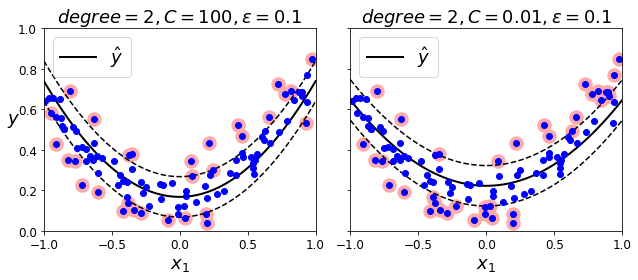

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

# 왼편 그래프 그리기
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)

# 오른편 그래프 그리기
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

### 회귀 모델 시간 복잡도

* `LinearSVR`: `LinearSVC`의 회귀 버전
    * 시간 복잡도가 훈련 세트의 크기에 비례해서 선형적으로 증가.
* `SVR`: `SVC`의 회귀 버전
    * 훈련 세트가 커지만 매우 느려짐.

###  참고사항

* SVM을 이상치 탐지에도 사용할 수 있다.
* 이상치 탐지에 대한 보다 자세한 설명은 
[Novelty and Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html)
를 참조한다.

# SVM 이론

In [ ]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

# 작은 가중치 벡터가 라지 마진을 만듭니다

In [ ]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

# 힌지 손실

In [ ]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

# 추가 내용

## 훈련 시간

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

In [ ]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

## 배치 경사 하강법을 사용한 선형 SVM 분류기 구현

In [ ]:
# 훈련 세트
X = iris["data"][:, (2, 3)] # # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [ ]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [ ]:
print(svm_clf.intercept_, svm_clf.coef_)

In [ ]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

In [ ]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # t==0이면 -1, t==1이면 +1
X_b = np.c_[np.ones((m, 1)), X]  # 편향 x0=1을 추가합니다
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


# 연습문제 해답

## 1. to 7.

부록 A 참조.

# 8.

_문제: 선형적으로 분리되는 데이터셋에 `LinearSVC`를 훈련시켜보세요. 그런 다음 같은 데이터셋에 `SVC`와`SGDClassifier`를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요._

Iris 데이터셋을 사용하겠습니다. Iris Setosa와 Iris Versicolor 클래스는 선형적으로 구분이 가능합니다.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

이 3개 모델의 결정 경계를 그려 보겠습니다:

In [ ]:
# 각 결정 경계의 기울기와 편향을 계산합니다
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# 결정 경계를 원본 스케일로 변환합니다
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# 세 개의 결정 경계를 모두 그립니다
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

아주 비슷하네요!

# 9.

_문제: MNIST 데이터셋에 SVM 분류기를 훈련시켜보세요. SVM 분류기는 이진 분류기라서 OvA 전략을 사용해 10개의 숫자를 분류해야 합니다. 처리 속도를 높이기 위해 작은 검증 세트로 하이퍼파라미터를 조정하는 것이 좋습니다. 어느 정도까지 정확도를 높일 수 있나요?_

먼저 데이터셋을 로드하고 훈련 세트와 테스트 세트로 나눕니다. `train_test_split()` 함수를 사용할 수 있지만 보통 처음 60,000개의 샘플을 훈련 세트로 사용하고 나머지는 10,000개를 테스트 세트로 사용합니다(이렇게 하면 다른 사람들의 모델과 성능을 비교하기 좋습니다):

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

많은 훈련 알고리즘은 훈련 샘플의 순서에 민감하므로 먼저 이를 섞는 것이 좋은 습관입니다. 하지만 이 데이터셋은 이미 섞여있으므로 이렇게 할 필요가 없습니다.

선형 SVM 분류기부터 시작해보죠. 이 모델은 자동으로 OvA(또는 OvR) 전략을 사용하므로 특별히 처리해 줄 것이 없습니다. 간단하네요!

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

훈련 세트에 대한 예측을 만들어 정확도를 측정해 보겠습니다(최종 모델을 선택해 훈련시킨 것이 아니기 때문에 아직 테스트 세트를 사용해서는 안됩니다):

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

MNIST에서 89.5% 정확도면 나쁜 성능입니다. 선형 모델이 MNIST 문제에 너무 단순하기 때문이지만 먼저 데이터의 스케일을 조정할 필요가 있습니다:

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

In [ ]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

훨씬 나아졌지만(에러율을 절반으로 줄였습니다) 여전히 MNIST에서 좋은 성능은 아닙니다. SVM을 사용한다면 커널 함수를 사용해야 합니다. RBF 커널(기본값)로 `SVC`를 적용해 보겠습니다.

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값인 `gamma="scale"`을 지정합니다.

In [ ]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

In [ ]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

아주 좋네요 6배나 적은 데이터에서 모델을 훈련시켰지만 더 좋은 성능을 얻었습니다. 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝을 해보겠습니다. 진행을 빠르게 하기 위해 작은 데이터셋으로 작업하겠습니다:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.best_score_

이 점수는 낮지만 1,000개의 샘플만 사용한 것을 기억해야 합니다. 전체 데이터셋으로 최선의 모델을 재훈련시켜 보겠습니다(몇 시간이 걸릴지 모르니 잠들기 전에 돌려 보세요):

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

아주 훌륭하네요! 이 모델을 선택하겠습니다. 이제 테스트 세트로 모델을 테스트합니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

아주 나쁘지 않지만 확실히 모델이 다소 과대적합되었습니다. 하이퍼파라미터를 조금 더 수정할 수 있지만(가령, `C`와/나 `gamma`를 감소시킵니다) 그렇게 하면 테스트 세트에 과대적합될 위험이 있습니다. 다른 사람들은 하이퍼파라미터 `C=5`와 `gamma=0.005`에서 더 나은 성능(98% 이상의 정확도)을 얻었습니다. 훈련 세트를 더 많이 사용해서 더 오래 랜덤 서치를 수행하면 이런 값을 얻을 수 있을지 모릅니다.

## 10.

_문제: 캘리포니아 주택 가격 데이터셋에 SVM 회귀를 훈련시켜보세요._

사이킷런의 `fetch_california_housing()` 함수를 사용해 데이터셋을 로드합니다:

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

훈련 세트와 테스트 세트로 나눕니다:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

데이터의 스케일을 조정하는 것을 잊지 마세요:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

먼저 간단한 `LinearSVR`을 훈련시켜 보죠:

In [ ]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

훈련 세트에 대한 성능을 확인해 보겠습니다:

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

RMSE를 확인해 보겠습니다:

In [ ]:
np.sqrt(mse)

훈련 세트에서 타깃은 만달러 단위입니다. RMSE는 기대할 수 있는 에러의 정도를 대략 가늠하게 도와줍니다(에러가 클수록 큰 폭으로 증가합니다). 이 모델의 에러가 대략 $10,000 정도로 예상할 수 있습니다. 썩 훌륭하지 않네요. RBF 커널이 더 나을지 확인해 보겠습니다. 하이퍼파라미터 `C`와 `gamma`의 적절한 값을 찾기 위해 교차 검증을 사용한 랜덤 서치를 적용하겠습니다:

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

In [ ]:
rnd_search_cv.best_estimator_

이제 훈련 세트에서 RMSE를 측정해 보겠습니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

선형 모델보다 훨씬 나아졌네요. 이 모델을 선택하고 테스트 세트에서 평가해 보겠습니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)